**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**

---

# Cell annotation to determine Maternal or Fetal origin
Using the output clusters from Souporcell deconvolution runs. These clusters were matched using the *share.py* script from SoC, matching results of the script were manually analysed

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import sys
import anndata
import scvi

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
for folder in ['../results/images/integrated/','../results/images/integrated/SoC_maternalFoetal/']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        #loop over the subfolders of the rawdata folder

In [3]:
def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/integrated/SoC_maternalFoetal/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
absl                NA
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiw

'/opt/conda/bin/python'

In [4]:
def identityTransfer(data_CellsNewID, data, field='identity', mode='adata'):
    
    '''
    Function to transfer the value in a .obs column, modifying only the cells included in adata_CellsNewID
    
    Parameters:
        data_CellsNewID: anndata/dataframe object with cells. These should have in their .obs[field] the new values to be transfer to data
        mode: 'adata' expects to receive an adata object with .obs instance inside. 'df' expects a pandas dataframe.
        data: anndata/dataframe object to modify. The value in .obs[field] will be modified for all the cells in adata_CellsNewID
        field: column name in adata.obs/Dataframe to operate in
        
    '''
    
    if mode =='adata':
        #converting categorical into strings to introduce new categories
        data.obs[field]=data.obs[field].astype("string")


        #assigning the new categories to the cells in adata
        for cell in data_CellsNewID.obs.index:
            data.obs[field][cell] = data_CellsNewID.obs[field][cell]

        #Returning strings into categorical 
        data.obs[field]=data.obs[field].astype("category")

        return(data)

    
    if mode =='df':
        #converting categorical into strings to introduce new categories
        data[field]=data[field].astype("string")


        #assigning the new categories to the cells in data
        for cell in data_CellsNewID.index:
            data[field][cell] = data_CellsNewID[field][cell]

        #Returning strings into categorical 
        data[field]=data[field].astype("category")

        return(data)

In [5]:
#Function to add the souporcell id

def add_souporcell_id(adata_obj, cell_id):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    
    if curr_sample in samples:
        #print(curr_sample)
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_available')

In [6]:
sc.set_figure_params(figsize=(6,6))

In [7]:
adata= sc.read('../results/scVI/rna5_scVIintegrated_latent30_noDoublets_20230707.h5ad')

In [8]:
adata

AnnData object with n_obs × n_vars = 164198 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type_2022', 'cell_type'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', 'cell_type_2022_colors', 'cell_type_colors', 'celltype_predictions_colors', 'donor_id_colors', 'hpi_colors', 'hvg', 'infection_colors', 'leiden', 'leiden_scvi_co

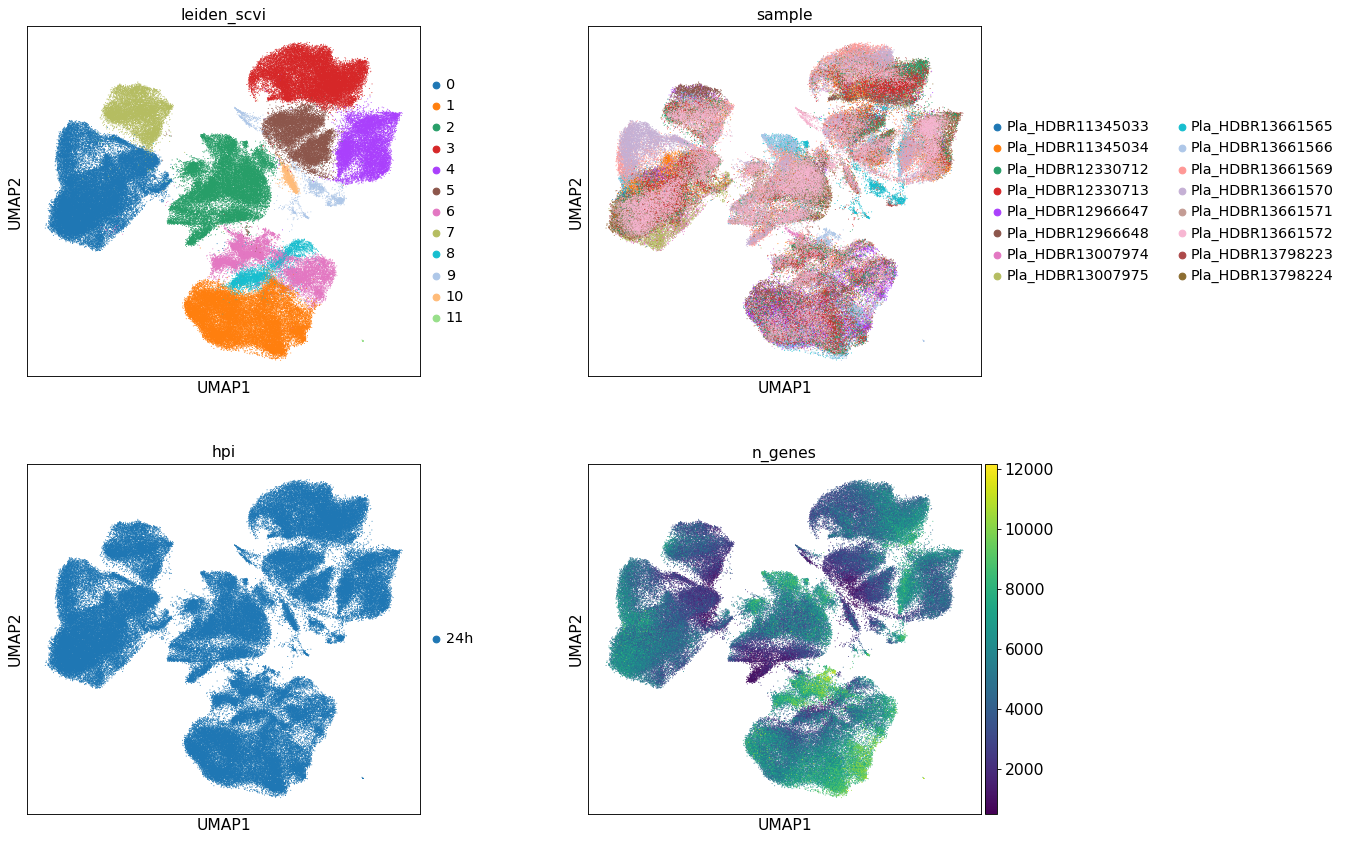

In [9]:
# use scVI imputed values for plotting
sc.pl.umap(adata, color=["leiden_scvi",'sample',#'donor_souporcell', 
                         'hpi','n_genes' ]
           ,ncols=2, size=3, wspace=0.3, save='_scVI_latent30.pdf')

In [10]:
#adata.write('../results/scVI/rna6_scVIintegrated_latent20_CleanV1_20230707.h5ad')

In [11]:
#adata= sc.read('/nfs/team292/er13/placInf_All/results/scVI/rna6c_scVIintegrated_Clean_adata_20220928.h5ad')

In [12]:
adata.obs['sample_barcode']=adata.obs.index.astype('string')

# Adding SoC Maternal-Foetal annotation: *T. gondii* experiment

In [12]:
#samples = list(np.unique(adata.obs['sample']))

In [13]:
samples=['Pla_HDBR13007974','Pla_HDBR13007975',#'Pla_HDBR13007976','Pla_HDBR13007977',
         'Pla_HDBR13798223','Pla_HDBR13798224']#,'Pla_HDBR13798225','Pla_HDBR13798226']

In [14]:
# reading in souporcell outputs
# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path = '../data/Toxoplasma/souporcell_MaternalFetal/'+sample+'/soc4/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #adding the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR13007974
sample Pla_HDBR13007975
sample Pla_HDBR13798223
sample Pla_HDBR13798224


In [15]:
#adata.obs=adata.obs.drop(['souporcell_MFgenotype'], axis=1)

In [16]:
## Subsetting only the samples from the toxoplasma run.
##
subsetDataFrame = adata.obs[adata.obs['sample'].isin(samples)].copy()

In [17]:
#Adding the SoC pooled status
#%%time
subsetDataFrame['souporcell_MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x))

### Creating a new column to save the Maternal/Fetal identity of the cells

In [18]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
subsetDataFrame['MFgenotype']= subsetDataFrame['souporcell_MFgenotype'].copy()

In [19]:
subsetDataFrame

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype,MFgenotype
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,...,9.562532,0.683827,3,dS2,0.770922,False,F,Fibroblast,0,0
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,...,9.735959,0.726819,1,VCT_fusing,0.997813,False,VCT_fusing,Trophoblast,3,3
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.736065,False,HBC,HBC,0,0
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.739323,False,HBC,HBC,0,0
Pla_HDBR13007974_AAACCCACAGTAGAAT,Pla_HDBR13007974,UI_24h,24h,UI,0.043799,14361.0,0,Pla_HDBR13007974_AAACCCACAGTAGAAT,0,scDonor_Tg1,...,9.735959,0.726819,0,dM1,0.470843,False,HBC,HBC,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13798224_TTTGTTGTCCGCATAA,Pla_HDBR13798224,Tg_24h,24h,Tg,0.068696,2300.0,0,Pla_HDBR13798224_TTTGTTGTCCGCATAA,1,scDonor_Tg3,...,9.639562,0.882047,5,dS1,0.703721,False,nan,Fibroblast,1,1
Pla_HDBR13798224_TTTGTTGTCCGGCTTT,Pla_HDBR13798224,Tg_24h,24h,Tg,0.005978,10706.0,0,Pla_HDBR13798224_TTTGTTGTCCGGCTTT,1,scDonor_Tg3,...,9.639562,0.882047,0,dM1,0.577989,False,HBC,HBC,1,1
Pla_HDBR13798224_TTTGTTGTCCTGATAG,Pla_HDBR13798224,Tg_24h,24h,Tg,0.028082,24678.0,0,Pla_HDBR13798224_TTTGTTGTCCTGATAG,0,scDonor_Tg4,...,9.409451,0.619359,3,fF1,1.000000,False,F,Fibroblast,2,2
Pla_HDBR13798224_TTTGTTGTCTCATGGA,Pla_HDBR13798224,Tg_24h,24h,Tg,0.072021,45945.0,0,Pla_HDBR13798224_TTTGTTGTCTCATGGA,1,scDonor_Tg3,...,9.639562,0.882047,1,VCT_CCC,0.981250,False,VCT_p,Trophoblast,1,1


### NOTE:
Remember that the annotation given by souporcell will vary from sample to sample, therefore, each sample must be analysed
separately. This was done individually, and here we will just directly assign the MF genotype to the SoC clusters

### Example of how the clusters are analysed and assigned
#### Sample: Pla_HDBR13007974

Rationale: we have cell types know to be either fetal (trophoblast and HBC) or maternal (PAMM1), by taking them as reference we can classify a cluster.

In [20]:
#Selecting the sample
sample = adata[adata.obs['sample'] == 'Pla_HDBR13007974']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [21]:
#assigning the SoC clusters to the sample metadata
sample.obs['souporcell_MFgenotype'] = sample.obs['sample_barcode'].apply(lambda x: add_souporcell_id(sample,x))

Trying to set attribute `.obs` of view, copying.


... storing 'souporcell_MFgenotype' as categorical


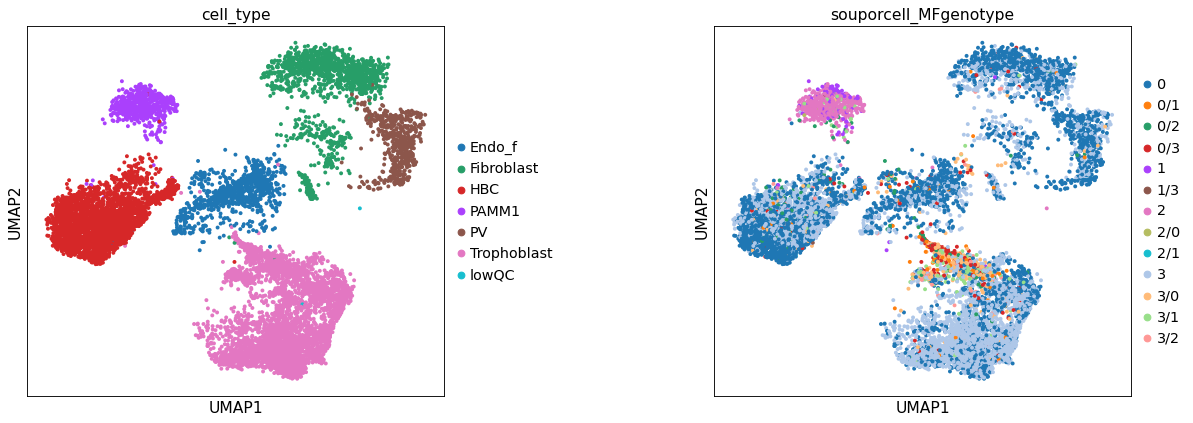

In [22]:
#clustering
sc.pl.umap(sample, color=['cell_type',"souporcell_MFgenotype"], wspace=0.5, size=50)

Now you can appreciate how clusters 0 and 3 are of fetal origin, as they predominate in the Trophoblast and HBC compartments. While clusters 1 and 2 belong to PAMM1, so they are maternal.

This same strategy is applied to all the samples.

In [23]:
def MFidentity(adata_obj, dataframe, cell_id):
    
    '''
    Function designed to assign the Maternal/Fetal genotype to each a cell. The assignation depends on the conditionals written
    below. This function returns the Maternal or Fetal genotype of each cell input.
    
    adata_obj: anndata object. Needed to map each cell to their corresponding sample of origin
    dataframe: metadata dataframe containing the SoC cluster of each cell. It must have the 'souporcell_MFgenotype' column.
    cell_id: cell id to test

    '''
    
    
    curr_id = dataframe.loc[cell_id, 'souporcell_MFgenotype'] #obtaining the SoC cluster from the metadata
    curr_sample = adata_obj.obs.loc[cell_id, 'sample'] #obtaining the sample of origin of the cell

    if curr_id == 'filtered_by_souporcell':
        return('filtered_by_souporcell')
    
    if curr_sample == 'Pla_HDBR13007974':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR13007975':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR13007976':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '0/3':
            return('Fetal')
        if curr_id == '3/0':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR13007977':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        if curr_id == '2/3':
            return('Fetal')
        if curr_id == '3/2':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13798223':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Maternal')
        if curr_id == '1/2':
            return('Fetal')
        if curr_id == '2/1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13798224':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Maternal')
        if curr_id == '1/2':
            return('Fetal')
        if curr_id == '2/1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13798225':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Maternal')
        if curr_id == '0/2':
            return('Fetal')
        if curr_id == '2/0':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13798226':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Maternal')
        if curr_id == '0/1':
            return('Fetal')
        if curr_id == '1/0':
            return('Fetal')
        else:
            return('Doublet')

In [24]:
subsetDataFrame['sample_barcode']= subsetDataFrame['sample_barcode'].astype('string')

In [25]:
%%time
subsetDataFrame['MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: MFidentity(adata,subsetDataFrame, x))

CPU times: user 1.13 s, sys: 3.95 ms, total: 1.13 s
Wall time: 1.13 s


In [26]:
subsetDataFrame.head()

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype,MFgenotype
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,...,9.562532,0.683827,3,dS2,0.770922,False,F,Fibroblast,0,Maternal
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,...,9.735959,0.726819,1,VCT_fusing,0.997813,False,VCT_fusing,Trophoblast,3,Fetal
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.736065,False,HBC,HBC,0,Maternal
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.739323,False,HBC,HBC,0,Maternal
Pla_HDBR13007974_AAACCCACAGTAGAAT,Pla_HDBR13007974,UI_24h,24h,UI,0.043799,14361.0,0,Pla_HDBR13007974_AAACCCACAGTAGAAT,0,scDonor_Tg1,...,9.735959,0.726819,0,dM1,0.470843,False,HBC,HBC,3,Fetal


In [27]:
subsetDataFrame.MFgenotype.head()

Pla_HDBR13007974_AAACCCAAGCGTTGTT    Maternal
Pla_HDBR13007974_AAACCCAAGTAGTCAA       Fetal
Pla_HDBR13007974_AAACCCACAATGAACA    Maternal
Pla_HDBR13007974_AAACCCACAGAGAGGG    Maternal
Pla_HDBR13007974_AAACCCACAGTAGAAT       Fetal
Name: MFgenotype, dtype: object

In [28]:
#adata= sc.read('../results/scVI/S2_scVIintegrated_adata_latent30_cleanV3.h5ad')

In [29]:
subsetDataFrameTg=subsetDataFrame.copy()

# Adding SoC Maternal-Foetal annotation: *L. monocytogenes* experiment

In [31]:
#samples = list(np.unique(adata.obs['sample']))

In [30]:
samples=['Pla_HDBR12330712','Pla_HDBR12330713', #'Pla_HDBR12330714', 'Pla_HDBR12330715',
        'Pla_HDBR13661571','Pla_HDBR13661572']#,'Pla_HDBR13661575','Pla_HDBR13661576']

In [31]:
# reading in souporcell outputs
# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path = '../data/Listeria/souporcell_MaternalFetal/'+sample+'/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #adding the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR12330712
sample Pla_HDBR12330713
sample Pla_HDBR13661571
sample Pla_HDBR13661572


In [32]:
#adata.obs=adata.obs.drop(['souporcell_MFgenotype'], axis=1)

In [33]:
## Subsetting only the samples from the toxoplasma run.
##
subsetDataFrame = adata.obs[adata.obs['sample'].isin(samples)].copy()

In [34]:
#Adding the SoC pooled status
#%%time

subsetDataFrame['souporcell_MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x))

### Creating a new column to save the Maternal/Fetal identity of the cells

In [35]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
subsetDataFrame['MFgenotype']= subsetDataFrame['souporcell_MFgenotype'].copy()

### NOTE:
Remember that the annotation given by souporcell will vary from sample to sample, therefore, each sample must be analysed
separately. This was done individually, and here we will just directly assign the MF genotype to the SoC clusters

In [36]:
adata.obs

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,...,9,0,9.562532,0.683827,3,dS2,0.770922,False,F,Fibroblast
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,...,8,0,9.735959,0.726819,1,VCT_fusing,0.997813,False,VCT_fusing,Trophoblast
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,...,9,0,9.562532,0.683827,0,HOFB,0.736065,False,HBC,HBC
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,...,9,0,9.562532,0.683827,0,HOFB,0.739323,False,HBC,HBC
Pla_HDBR13007974_AAACCCACAGTAGAAT,Pla_HDBR13007974,UI_24h,24h,UI,0.043799,14361.0,0,Pla_HDBR13007974_AAACCCACAGTAGAAT,0,scDonor_Tg1,...,8,0,9.735959,0.726819,0,dM1,0.470843,False,HBC,HBC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661572_TTTGTTGCATGTCTAG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.024774,2099.0,2,Pla_HDBR13661572_TTTGTTGCATGTCTAG,not_pooled,Hrv236,...,6,0,9.104866,1.062307,5,fF2,0.914350,False,nan,Fibroblast
Pla_HDBR13661572_TTTGTTGGTAGGCAAC,Pla_HDBR13661572,Lm_24h,24h,Lm,0.061145,6967.0,2,Pla_HDBR13661572_TTTGTTGGTAGGCAAC,not_pooled,Hrv236,...,6,0,9.104866,1.062307,5,iEVT,0.270191,False,nan,Fibroblast
Pla_HDBR13661572_TTTGTTGGTGCTTATG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037710,22938.0,2,Pla_HDBR13661572_TTTGTTGGTGCTTATG,not_pooled,Hrv236,...,6,0,9.104866,1.062307,2,Endo_F,0.986252,False,Endo_f,Endo_f
Pla_HDBR13661572_TTTGTTGGTGGTAACG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037474,5844.0,2,Pla_HDBR13661572_TTTGTTGGTGGTAACG,not_pooled,Hrv236,...,6,0,9.104866,1.062307,7,dM1,0.653951,False,PAMM1,PAMM1


In [37]:
def MFidentity(adata_obj, dataframe, cell_id):
        
    '''
    Function designed to assign the Maternal/Fetal genotype to each a cell. The assignation depends on the conditionals written
    below. This function returns the Maternal or Fetal genotype of each cell input.
    
    adata_obj: anndata object. Needed to map each cell to their corresponding sample of origin
    dataframe: metadata dataframe containing the SoC cluster of each cell. It must have the 'souporcell_MFgenotype' column.
    cell_id: cell id to test

    '''
    

    curr_id = dataframe.loc[cell_id, 'souporcell_MFgenotype'] #obtaining the SoC cluster from the metadata
    curr_sample = adata_obj.obs.loc[cell_id, 'sample'] #obtaining the sample of origin of the cell

    if curr_id == 'filtered_by_souporcell':
        return('filtered_by_souporcell')
        
    if curr_sample == 'Pla_HDBR12330712':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        if curr_id == 'filtered_by_souporcell':
            return('filtered_by_souporcell')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR12330713':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR12330714':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '0/3':
            return('Fetal')
        if curr_id == '3/0':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR12330715':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        if curr_id == '3/1':
            return('Fetal')
        if curr_id == '2/3':
            return('Fetal')
        if curr_id == '3/2':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR13661571':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet') 
        
    if curr_sample == 'Pla_HDBR13661572':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')

       
    if curr_sample == 'Pla_HDBR13661575':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        else:
            return('Doublet')

       
    if curr_sample == 'Pla_HDBR13661576':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')

In [38]:
subsetDataFrame['sample_barcode']= subsetDataFrame['sample_barcode'].astype('string')

In [39]:
subsetDataFrame.head()

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype,MFgenotype
Pla_HDBR12330712_AAACCCAAGACCATGG,Pla_HDBR12330712,UI_24h,24h,UI,0.022749,2066.0,2,Pla_HDBR12330712_AAACCCAAGACCATGG,1,Hrv136,...,9.641021,0.885779,0,HOFB,0.874573,False,nan,HBC,3,3
Pla_HDBR12330712_AAACCCAAGTCGTTAC,Pla_HDBR12330712,UI_24h,24h,UI,0.039273,25870.0,2,Pla_HDBR12330712_AAACCCAAGTCGTTAC,1,Hrv136,...,9.641021,0.885779,1,SCT,0.996335,False,VCT_fusing,Trophoblast,3,3
Pla_HDBR12330712_AAACCCACAACCGTAT,Pla_HDBR12330712,UI_24h,24h,UI,0.062230,26113.0,2,Pla_HDBR12330712_AAACCCACAACCGTAT,1,Hrv136,...,9.641021,0.885779,1,VCT,0.991680,False,VCT,Trophoblast,3,3
Pla_HDBR12330712_AAACCCACACCAGGTC,Pla_HDBR12330712,UI_24h,24h,UI,0.053773,3459.0,2,Pla_HDBR12330712_AAACCCACACCAGGTC,0,Hrv135,...,9.361705,0.794673,2,Endo_M,0.997482,False,nan,Endo_f,1,1
Pla_HDBR12330712_AAACCCACATCCGTTC,Pla_HDBR12330712,UI_24h,24h,UI,0.031704,4132.0,2,Pla_HDBR12330712_AAACCCACATCCGTTC,1,Hrv136,...,9.641021,0.885779,5,fF2,0.999986,False,nan,Fibroblast,3,3


In [40]:
%%time
subsetDataFrame['MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: MFidentity(adata,subsetDataFrame, x))

CPU times: user 1.05 s, sys: 722 µs, total: 1.05 s
Wall time: 1.05 s


In [41]:
subsetDataFrameLm=subsetDataFrame.copy()

In [42]:
subsetDataFrameLm

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype,MFgenotype
Pla_HDBR12330712_AAACCCAAGACCATGG,Pla_HDBR12330712,UI_24h,24h,UI,0.022749,2066.0,2,Pla_HDBR12330712_AAACCCAAGACCATGG,1,Hrv136,...,9.641021,0.885779,0,HOFB,0.874573,False,nan,HBC,3,Fetal
Pla_HDBR12330712_AAACCCAAGTCGTTAC,Pla_HDBR12330712,UI_24h,24h,UI,0.039273,25870.0,2,Pla_HDBR12330712_AAACCCAAGTCGTTAC,1,Hrv136,...,9.641021,0.885779,1,SCT,0.996335,False,VCT_fusing,Trophoblast,3,Fetal
Pla_HDBR12330712_AAACCCACAACCGTAT,Pla_HDBR12330712,UI_24h,24h,UI,0.062230,26113.0,2,Pla_HDBR12330712_AAACCCACAACCGTAT,1,Hrv136,...,9.641021,0.885779,1,VCT,0.991680,False,VCT,Trophoblast,3,Fetal
Pla_HDBR12330712_AAACCCACACCAGGTC,Pla_HDBR12330712,UI_24h,24h,UI,0.053773,3459.0,2,Pla_HDBR12330712_AAACCCACACCAGGTC,0,Hrv135,...,9.361705,0.794673,2,Endo_M,0.997482,False,nan,Endo_f,1,Fetal
Pla_HDBR12330712_AAACCCACATCCGTTC,Pla_HDBR12330712,UI_24h,24h,UI,0.031704,4132.0,2,Pla_HDBR12330712_AAACCCACATCCGTTC,1,Hrv136,...,9.641021,0.885779,5,fF2,0.999986,False,nan,Fibroblast,3,Fetal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661572_TTTGTTGCATGTCTAG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.024774,2099.0,2,Pla_HDBR13661572_TTTGTTGCATGTCTAG,not_pooled,Hrv236,...,9.104866,1.062307,5,fF2,0.914350,False,nan,Fibroblast,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTAGGCAAC,Pla_HDBR13661572,Lm_24h,24h,Lm,0.061145,6967.0,2,Pla_HDBR13661572_TTTGTTGGTAGGCAAC,not_pooled,Hrv236,...,9.104866,1.062307,5,iEVT,0.270191,False,nan,Fibroblast,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTGCTTATG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037710,22938.0,2,Pla_HDBR13661572_TTTGTTGGTGCTTATG,not_pooled,Hrv236,...,9.104866,1.062307,2,Endo_F,0.986252,False,Endo_f,Endo_f,1,Fetal
Pla_HDBR13661572_TTTGTTGGTGGTAACG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037474,5844.0,2,Pla_HDBR13661572_TTTGTTGGTGGTAACG,not_pooled,Hrv236,...,9.104866,1.062307,7,dM1,0.653951,False,PAMM1,PAMM1,0,Maternal


# Adding SoC Maternal-Foetal annotation: *P. falciparum* experiment

In [45]:
#samples = list(np.unique(adata.obs['sample']))

In [46]:
#set(adata.obs['sample'])

In [43]:
samples=['Pla_HDBR11345033','Pla_HDBR11345034', 'Pla_HDBR12966647', 'Pla_HDBR12966648',
         'Pla_HDBR13661565','Pla_HDBR13661566',#'Pla_HDBR13661567','Pla_HDBR13661568',
         'Pla_HDBR13661569','Pla_HDBR13661570']#,'Pla_HDBR13661573','Pla_HDBR13661574']



In [44]:
# reading in souporcell outputs
# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path = '../data/Malaria/souporcell_MaternalFetal/'+sample+'/clusters.tsv'  #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #adding the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR11345033
sample Pla_HDBR11345034
sample Pla_HDBR12966647
sample Pla_HDBR12966648
sample Pla_HDBR13661565
sample Pla_HDBR13661566
sample Pla_HDBR13661569
sample Pla_HDBR13661570


In [45]:
#adata.obs=adata.obs.drop(['souporcell_MFgenotype'], axis=1)

In [46]:
## Subsetting only the samples from the toxoplasma run.
##
subsetDataFrame = adata.obs[adata.obs['sample'].isin(samples)].copy()

In [47]:
#Adding the SoC pooled status
#%%time

subsetDataFrame['souporcell_MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x))

In [48]:
subsetDataFrame

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype
Pla_HDBR11345033_AAACCCACAATAGTGA,Pla_HDBR11345033,UI_24h,24h,UI,0.033592,62782.0,1,Pla_HDBR11345033_AAACCCACAATAGTGA,not_pooled,Hrv124,...,0,9.220467,1.420440,3,fF1,0.980585,False,F,Fibroblast,2
Pla_HDBR11345033_AAACCCACAGCAAGAC,Pla_HDBR11345033,UI_24h,24h,UI,0.029803,42276.0,1,Pla_HDBR11345033_AAACCCACAGCAAGAC,not_pooled,Hrv124,...,0,9.220467,1.420440,3,dS2,0.663606,False,F,Fibroblast,2
Pla_HDBR11345033_AAACCCATCCTCACGT,Pla_HDBR11345033,UI_24h,24h,UI,0.044874,53750.0,1,Pla_HDBR11345033_AAACCCATCCTCACGT,not_pooled,Hrv124,...,0,9.220467,1.420440,0,HOFB,0.519538,False,HBC,HBC,2
Pla_HDBR11345033_AAACCCATCGTCTAAG,Pla_HDBR11345033,UI_24h,24h,UI,0.041213,32052.0,1,Pla_HDBR11345033_AAACCCATCGTCTAAG,not_pooled,Hrv124,...,0,9.220467,1.420440,0,HOFB,0.475956,False,HBC,HBC,0
Pla_HDBR11345033_AAACCCATCTCATTGT,Pla_HDBR11345033,UI_24h,24h,UI,0.027333,17047.0,1,Pla_HDBR11345033_AAACCCATCTCATTGT,not_pooled,Hrv124,...,0,9.220467,1.420440,3,dS2,0.741961,False,F,Fibroblast,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661570_TTTGTTGTCAGGAGAC,Pla_HDBR13661570,Pf_24h,24h,Pf,0.039853,11693.0,1,Pla_HDBR13661570_TTTGTTGTCAGGAGAC,not_pooled,Hrv236,...,0,9.104866,1.062307,4,dS2,0.898986,False,PV,PV,1
Pla_HDBR13661570_TTTGTTGTCCATATGG,Pla_HDBR13661570,Pf_24h,24h,Pf,0.029766,2822.0,1,Pla_HDBR13661570_TTTGTTGTCCATATGG,not_pooled,Hrv236,...,0,9.104866,1.062307,5,T_cells,0.357553,False,nan,Fibroblast,1
Pla_HDBR13661570_TTTGTTGTCCTTCAGC,Pla_HDBR13661570,Pf_24h,24h,Pf,0.120672,5892.0,1,Pla_HDBR13661570_TTTGTTGTCCTTCAGC,not_pooled,Hrv236,...,0,9.104866,1.062307,5,dS2,0.731122,False,nan,Fibroblast,1
Pla_HDBR13661570_TTTGTTGTCGCACGGT,Pla_HDBR13661570,Pf_24h,24h,Pf,0.054355,14019.0,1,Pla_HDBR13661570_TTTGTTGTCGCACGGT,not_pooled,Hrv236,...,0,9.104866,1.062307,0,dM1,0.834436,False,HBC,HBC,1


### Creating a new column to save the Maternal/Fetal identity of the cells

In [49]:
#COpying the value of the leiden cluster. The new column will help to change it's values for
# the cluster identity
subsetDataFrame['MFgenotype']= subsetDataFrame['souporcell_MFgenotype'].copy()

In [50]:
def MFidentity(adata_obj, dataframe, cell_id):

    '''
    Function designed to assign the Maternal/Fetal genotype to each a cell. The assignation depends on the conditionals written
    below. This function returns the Maternal or Fetal genotype of each cell input.
    
    adata_obj: anndata object. Needed to map each cell to their corresponding sample of origin
    dataframe: metadata dataframe containing the SoC cluster of each cell. It must have the 'souporcell_MFgenotype' column.
    cell_id: cell id to test

    '''
    
    curr_id = dataframe.loc[cell_id, 'souporcell_MFgenotype'] #obtaining the SoC cluster from the metadata
    curr_sample = adata_obj.obs.loc[cell_id, 'sample'] #obtaining the sample of origin of the cell
    
    if curr_id == 'filtered_by_souporcell':
        return('filtered_by_souporcell')
    
    if curr_sample == 'Pla_HDBR11345033':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '0/2':
            return('Fetal')
        if curr_id == '2/0':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR11345034':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '0/2':
            return('Fetal')
        if curr_id == '2/0':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR12966647':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '1/2':
            return('Fetal')
        if curr_id == '2/1':
            return('Fetal')
        else:
            return('Doublet')
        
    if curr_sample == 'Pla_HDBR12966648':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '0/2':
            return('Fetal')
        if curr_id == '2/0':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661565':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Maternal')
        if curr_id == '3':
            return('Fetal')
        if curr_id == '1/0':
            return('Fetal')
        if curr_id == '1/3':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661566':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Fetal')
        if curr_id == '2':
            return('Fetal')
        if curr_id == '3':
            return('Maternal')
        if curr_id == '1/0':
            return('Fetal')
        if curr_id == '2/1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661567':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661568':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661569':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661570':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661573':
        if curr_id == '0':
            return('Fetal')
        if curr_id == '1':
            return('Maternal')
        else:
            return('Doublet')

    if curr_sample == 'Pla_HDBR13661574':
        if curr_id == '0':
            return('Maternal')
        if curr_id == '1':
            return('Fetal')
        else:
            return('Doublet')



In [51]:
%%time
subsetDataFrame['MFgenotype'] = subsetDataFrame['sample_barcode'].apply(lambda x: MFidentity(adata,subsetDataFrame, x))

CPU times: user 1.63 s, sys: 151 µs, total: 1.63 s
Wall time: 1.63 s


In [52]:
subsetDataFramePf=subsetDataFrame.copy()

### Concatenating the Maternal-Fetal annotation and adding it to adata metadata

In [53]:
subsetDataFramePf= subsetDataFramePf[['souporcell_MFgenotype','MFgenotype']]
subsetDataFrameTg= subsetDataFrameTg[['souporcell_MFgenotype','MFgenotype']]
subsetDataFrameLm= subsetDataFrameLm[['souporcell_MFgenotype','MFgenotype']]

In [54]:
MFgenotype= pd.concat([subsetDataFrameTg,subsetDataFramePf,subsetDataFrameLm], axis=0)

In [55]:
MFgenotype

,souporcell_MFgenotype,MFgenotype
Pla_HDBR13007974_AAACCCAAGCGTTGTT,0,Maternal
Pla_HDBR13007974_AAACCCAAGTAGTCAA,3,Fetal
Pla_HDBR13007974_AAACCCACAATGAACA,0,Maternal
Pla_HDBR13007974_AAACCCACAGAGAGGG,0,Maternal
Pla_HDBR13007974_AAACCCACAGTAGAAT,3,Fetal
...,...,...
Pla_HDBR13661572_TTTGTTGCATGTCTAG,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTAGGCAAC,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTGCTTATG,1,Fetal
Pla_HDBR13661572_TTTGTTGGTGGTAACG,0,Maternal


In [56]:
#temp= adata.obs.copy()

In [57]:
#adata.obs['souporcell_MFgenotype']= MFgenotype['souporcell_MFgenotype']
#adata.obs['MFgenotype']=MFgenotype['MFgenotype']

In [58]:
adata.obs= adata.obs.join(MFgenotype)

### Clustering

In [59]:
sc.set_figure_params(figsize=(5,5))

... storing 'souporcell_MFgenotype' as categorical
... storing 'MFgenotype' as categorical


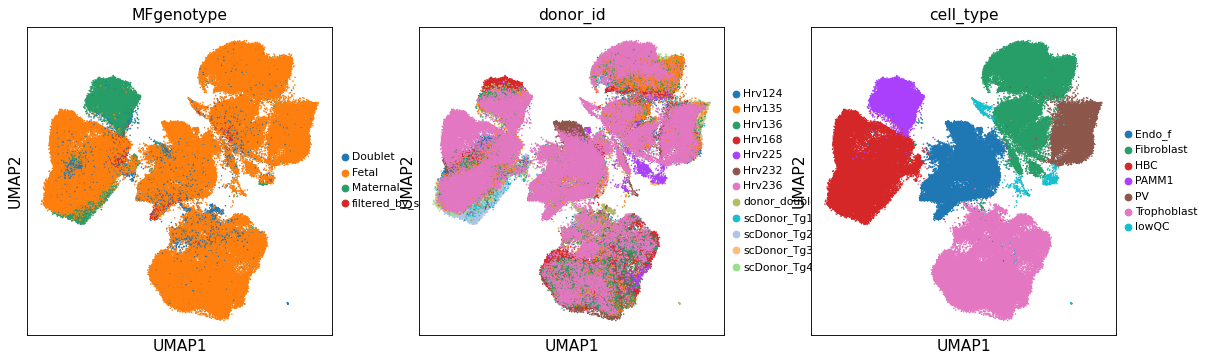

In [60]:
sc.pl.umap(adata, color=['MFgenotype','donor_id','cell_type'], legend_fontsize='x-small', size=8)

In [61]:
adata.obs

,sample,stage,hpi,infection,percent_mito,n_counts,batch,sample_barcode,assignment_SoC,donor_id,...,_scvi_local_l_mean,_scvi_local_l_var,leiden_scvi,celltype_predictions,probabilities,scrublet_doublet,cell_type_2022,cell_type,souporcell_MFgenotype,MFgenotype
Pla_HDBR13007974_AAACCCAAGCGTTGTT,Pla_HDBR13007974,UI_24h,24h,UI,0.019590,6432.0,0,Pla_HDBR13007974_AAACCCAAGCGTTGTT,1,scDonor_Tg2,...,9.562532,0.683827,3,dS2,0.770922,False,F,Fibroblast,0,Maternal
Pla_HDBR13007974_AAACCCAAGTAGTCAA,Pla_HDBR13007974,UI_24h,24h,UI,0.045489,49221.0,0,Pla_HDBR13007974_AAACCCAAGTAGTCAA,0,scDonor_Tg1,...,9.735959,0.726819,1,VCT_fusing,0.997813,False,VCT_fusing,Trophoblast,3,Fetal
Pla_HDBR13007974_AAACCCACAATGAACA,Pla_HDBR13007974,UI_24h,24h,UI,0.045332,9243.0,0,Pla_HDBR13007974_AAACCCACAATGAACA,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.736065,False,HBC,HBC,0,Maternal
Pla_HDBR13007974_AAACCCACAGAGAGGG,Pla_HDBR13007974,UI_24h,24h,UI,0.031214,7753.0,0,Pla_HDBR13007974_AAACCCACAGAGAGGG,1,scDonor_Tg2,...,9.562532,0.683827,0,HOFB,0.739323,False,HBC,HBC,0,Maternal
Pla_HDBR13007974_AAACCCACAGTAGAAT,Pla_HDBR13007974,UI_24h,24h,UI,0.043799,14361.0,0,Pla_HDBR13007974_AAACCCACAGTAGAAT,0,scDonor_Tg1,...,9.735959,0.726819,0,dM1,0.470843,False,HBC,HBC,3,Fetal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661572_TTTGTTGCATGTCTAG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.024774,2099.0,2,Pla_HDBR13661572_TTTGTTGCATGTCTAG,not_pooled,Hrv236,...,9.104866,1.062307,5,fF2,0.914350,False,nan,Fibroblast,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTAGGCAAC,Pla_HDBR13661572,Lm_24h,24h,Lm,0.061145,6967.0,2,Pla_HDBR13661572_TTTGTTGGTAGGCAAC,not_pooled,Hrv236,...,9.104866,1.062307,5,iEVT,0.270191,False,nan,Fibroblast,1/0,Doublet
Pla_HDBR13661572_TTTGTTGGTGCTTATG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037710,22938.0,2,Pla_HDBR13661572_TTTGTTGGTGCTTATG,not_pooled,Hrv236,...,9.104866,1.062307,2,Endo_F,0.986252,False,Endo_f,Endo_f,1,Fetal
Pla_HDBR13661572_TTTGTTGGTGGTAACG,Pla_HDBR13661572,Lm_24h,24h,Lm,0.037474,5844.0,2,Pla_HDBR13661572_TTTGTTGGTGGTAACG,not_pooled,Hrv236,...,9.104866,1.062307,7,dM1,0.653951,False,PAMM1,PAMM1,0,Maternal


### Cleaning the cells filtered by SoC

In [62]:
adata = adata[adata.obs['MFgenotype'] != 'filtered_by_souporcell']
#adata = adata[adata.obs['MFgenotype'] != 'Doublet']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [63]:
adata

View of AnnData object with n_obs × n_vars = 163461 × 36601
    obs: 'sample', 'stage', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden_scvi', 'celltype_predictions', 'probabilities', 'scrublet_doublet', 'cell_type_2022', 'cell_type', 'souporcell_MFgenotype', 'MFgenotype'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', 'cell_type_2022_colors', 'cell_type_colors', 'celltype_predictions_colors', 'donor_id_colors', 'hpi_colors', 'hvg'

### Saving the object

In [64]:
adata.write('../results/scVI/rna6_scVIintegrated_latent30_20230707.h5ad')